## Extra Trees for classifying endangered languages
**Summary** 

The notebook focuses on training, implementing, and tuning a extra trees model to predict language endangerment levels based on different socioeconomic features. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import (ExtraTreesClassifier)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from sklearn.metrics import log_loss
warnings.filterwarnings('ignore')

In [3]:
# Load and inspect the final_dataset
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

In [4]:
comma_separated_names = ','.join(df['official_name'].astype(str))

# Write to file
with open('official_names.txt', 'w') as file:
    file.write(comma_separated_names)

In [5]:
# Create a new column with combined classes
df_modified = df.copy()

def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_modified['level_combined'] = df_modified['level'].apply(combine_endangered_classes)

In [6]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national', 
                   'widely_spoken', 'country_count', 'max_urbanization', 
                   'max_internet_use']
    
    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
    
    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']
    
    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])
    
    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']
    
    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    
    return df_feat

In [7]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

## Base Extra Trees Model (no tuning)
Granular levels:
- Train Accuracy: 0.951
- Validation Accuracy: 0.709
- Test Accuracy: 0.723
- *Notes:* Large gap between training and validation/test accuracies indicates overfitting.

Grouped levels:
- Train Accuracy: 0.970
- Validation Accuracy: 0.875
- Test Accuracy: 0.859
- *Notes:* Overfitting still exists, as indicated by the substantial gap between train and validation accuracy, but it decreases significantly by using the grouped levels instead of the granular levels.

In [8]:
def train_extra_trees_model(dataframe, target_column):
    """
    Train Extra Trees model (sklearn version)
    """
    print("Training Extra Trees model...")
    
    # Prepare features
    df_feat = prepare_features_with_engineering(dataframe)
    
    # Select features
    feature_cols = list(df_feat.columns[4:12]) + [
        'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers',
        'speakers_urbanization', 'speakers_internet'
    ]
    
    X = df_feat[feature_cols]
    y = df_feat[target_column]
    
    # Split into train (80) and test (20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
    )
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_scaled, y_train)
    
    # Train Extra Trees
    et_model = ExtraTreesClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    et_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_train_pred = et_model.predict(X_train_balanced)
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
    y_pred = et_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    y_val_pred = et_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"Train Accuracy: {train_accuracy:.3f}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return et_model, scaler, feature_cols, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X_train_balanced, y_train_balanced

In [9]:
# Granular dataset
gb_model1, scaler1, features1, X_train_scaled1, X_val_scaled1, X_test_scaled1, y_train1, y_val1, y_test1, X_train_balanced1, y_train_balanced1 = train_extra_trees_model(df, 'level')

Training Extra Trees model...
imbalanced-learn not available. Install with: pip install imbalanced-learn
Train Accuracy: 0.801
Validation Accuracy: 0.742
Test Accuracy: 0.756

Validation Classification Report:
                       precision    recall  f1-score   support

              At risk       0.57      0.92      0.71        13
Critically Endangered       0.77      0.70      0.73        77
           Endangered       0.78      0.72      0.75       130
              Extinct       0.97      0.97      0.97        35
       Not Endangered       0.95      1.00      0.97        18
  Severely Endangered       0.56      0.48      0.52        67
           Threatened       0.72      0.85      0.78       149
           Vulnerable       0.74      0.66      0.70        85

             accuracy                           0.74       574
            macro avg       0.76      0.79      0.77       574
         weighted avg       0.74      0.74      0.74       574


Test Classification Report:
  

In [10]:
# Grouped dataset
et_model2, scaler2, features2, X_train_scaled2, X_val_scaled2, X_test_scaled2, y_train2, y_val2, y_test2, X_train_balanced2, y_train_balanced2 = train_extra_trees_model(df_modified, 'level_combined')

Training Extra Trees model...
imbalanced-learn not available. Install with: pip install imbalanced-learn
Train Accuracy: 0.875
Validation Accuracy: 0.885
Test Accuracy: 0.878

Validation Classification Report:
                   precision    recall  f1-score   support

          At Risk       0.89      0.92      0.90       247
       Endangered       0.79      0.76      0.78       131
          Extinct       1.00      1.00      1.00        34
Highly Endangered       0.92      0.90      0.91       144
   Not Endangered       0.95      1.00      0.97        18

         accuracy                           0.89       574
        macro avg       0.91      0.92      0.91       574
     weighted avg       0.88      0.89      0.88       574


Test Classification Report:
                   precision    recall  f1-score   support

          At Risk       0.89      0.92      0.91       247
       Endangered       0.77      0.79      0.78       131
          Extinct       1.00      0.97      0.99 

## Tuned Extra Trees Model
The tuned version involves optimizing four hyperparameters-n_estimators, max_depth, learning_rate, and subsample-to see which combinations most improve model performance.

Granular levels:
 - Train accuracy: 0.8066
 - Validation accuracy: 0.7561
 - Log loss: 1.0561

Grouped levels:
 - Train accuracy: 0.9123
 - Validation accuracy: 0.8937
 - Log loss: 0.4729


In [11]:
from sklearn.metrics import log_loss

def et_tuner(param_dict, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    best_model = None
    best_score = 0
    best_train = 0
    best_log_loss = float('inf')  # Initialize best log loss
    best_params = {}
    
    # Common parameters to tune for Extra Trees:
    for est, depth, min_split, min_leaf in itertools.product(
        param_dict['n_estimators'],      # e.g., [100, 200, 300, 500]
        param_dict['max_depth'],         # e.g., [10, 15, 20, None]
        param_dict['min_samples_split'], # e.g., [2, 5, 10]
        param_dict['min_samples_leaf'],  # e.g., [1, 2, 4]
    ):
        model = ExtraTreesClassifier(
            n_estimators=est,  # Use the parameter!
            max_depth=depth,   # Use the parameter!
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        
        # Compute scores
        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_val, y_val)
        
        # Compute log loss using predict_proba
        val_proba = model.predict_proba(X_val)
        val_log_loss = log_loss(y_val, val_proba)
        
        # Update best model if validation score improves
        if val_acc > best_score:
            best_model = model
            best_score = val_acc
            best_train = train_acc
            best_log_loss = val_log_loss  # Store the best log loss
            best_params = {
                'n_estimators': est,
                'max_depth': depth,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf
            }
    
    print(f"Train accuracy: {best_train:.4f}")
    print(f"Validation accuracy: {best_score:.4f}")
    print(f"Log loss: {best_log_loss:.4f}")  # Use the stored log loss
    print(f"Best hyperparameters: {best_params}")
    
    # Calculate test accuracy if test data is provided
    test_accuracy = None
    if X_test is not None and y_test is not None:
        test_accuracy = best_model.score(X_test, y_test)
        print(f"Test accuracy: {test_accuracy:.4f}")
    
    return best_model, best_score, best_log_loss, best_params, test_accuracy


In [12]:
# Granular levels
tuning_dict = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
}

best_model1, best_score1, best_loss1, best_params1, test_acc1 = et_tuner(
    tuning_dict,
    X_train_balanced1,
    y_train_balanced1,
    X_val_scaled1,
    y_val1,
    X_test_scaled1,  # Add test data
    y_test1          # Add test labels
)

Train accuracy: 0.8066
Validation accuracy: 0.7561
Log loss: 1.0561
Best hyperparameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}
Test accuracy: 0.7509


In [13]:
# Granular levels
tuning_dict = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
}

best_model2, best_score2, best_loss2, best_params2, test_acc2 = et_tuner(
    tuning_dict,
    X_train_balanced2,
    y_train_balanced2,
    X_val_scaled2,
    y_val2,
    X_test_scaled2,  # Add test data
    y_test2          # Add test labels
)

Train accuracy: 0.9123
Validation accuracy: 0.8937
Log loss: 0.4729
Best hyperparameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1}
Test accuracy: 0.8780


In [14]:
def plot_feature_importance(model, feature_names, model_name, X_test=None, y_test=None, 
                          scaler=None, use_permutation=False):
    """
    Plot feature importance for a given model
    """
    plt.figure(figsize=(10, 8))
    
    if use_permutation and X_test is not None and y_test is not None:
        # Use permutation importance for models without built-in feature importance
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            X_test_scaled = X_test
            
        perm_importance = permutation_importance(model, X_test_scaled, y_test, 
                                               n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean
        std_devs = perm_importance.importances_std
    else:
        # Use built-in feature importance
        importances = model.feature_importances_
        std_devs = None
    
    # Create dataframe for sorting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    # Create horizontal bar plot
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    
    # Color bars by importance
    colors = plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels
    for i, (idx, row) in enumerate(importance_df.iterrows()):
        plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                va='center', fontsize=9)
    
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'{model_name} - Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print(f"\nTop 10 Features for {model_name}:")
    print(importance_df.nlargest(10, 'importance').to_string(index=False))

def plot_all_feature_importances(et_model, features):
    """
    Plot feature importances for all models
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # 1. Extra Trees
    if et_model is not None:
        plot_feature_importance(et_model, features, "Extra Trees")
    

def create_feature_importance_comparison(et_model, features):
    """
    Create a comparison heatmap of feature importances across tree-based models
    """
    models_with_importance = []
    importance_matrix = []
    
    if et_model is not None and hasattr(et_model, 'feature_importances_'):
        models_with_importance.append('Extra Trees')
        importance_matrix.append(et_model.feature_importances_)
    
    if len(importance_matrix) > 1:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        
        # Normalize importances for better comparison
        importance_matrix = np.array(importance_matrix)
        importance_matrix = importance_matrix / importance_matrix.sum(axis=1, keepdims=True)
        
        # Create dataframe
        importance_df = pd.DataFrame(importance_matrix.T, 
                                   index=features,
                                   columns=models_with_importance)
        
        # Sort by average importance
        importance_df['Average'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Average', ascending=False)
        importance_df = importance_df.drop('Average', axis=1)
        
        # Plot heatmap
        sns.heatmap(importance_df.head(20).T, cmap='YlOrRd', annot=True, fmt='.3f', 
                    cbar_kws={'label': 'Normalized Importance'})
        plt.title('Feature Importance Comparison Across Models (Top 20)', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def analyze_feature_correlations(df, features, top_n=10):
    """
    Analyze correlations between top features
    """
    # Prepare features
    df_feat = prepare_features_with_engineering(df)
    
    # Get feature data
    feature_data = df_feat[features]
    
    # Calculate correlation matrix
    corr_matrix = feature_data.corr()
    
    # Plot correlation heatmap for top features
    plt.figure(figsize=(10, 8))
    
    # Select top features based on variance
    top_features = feature_data.var().nlargest(top_n).index.tolist()
    
    sns.heatmap(corr_matrix.loc[top_features, top_features], 
                annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1)
    plt.title(f'Feature Correlation Matrix (Top {top_n} by Variance)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


FEATURE IMPORTANCE ANALYSIS


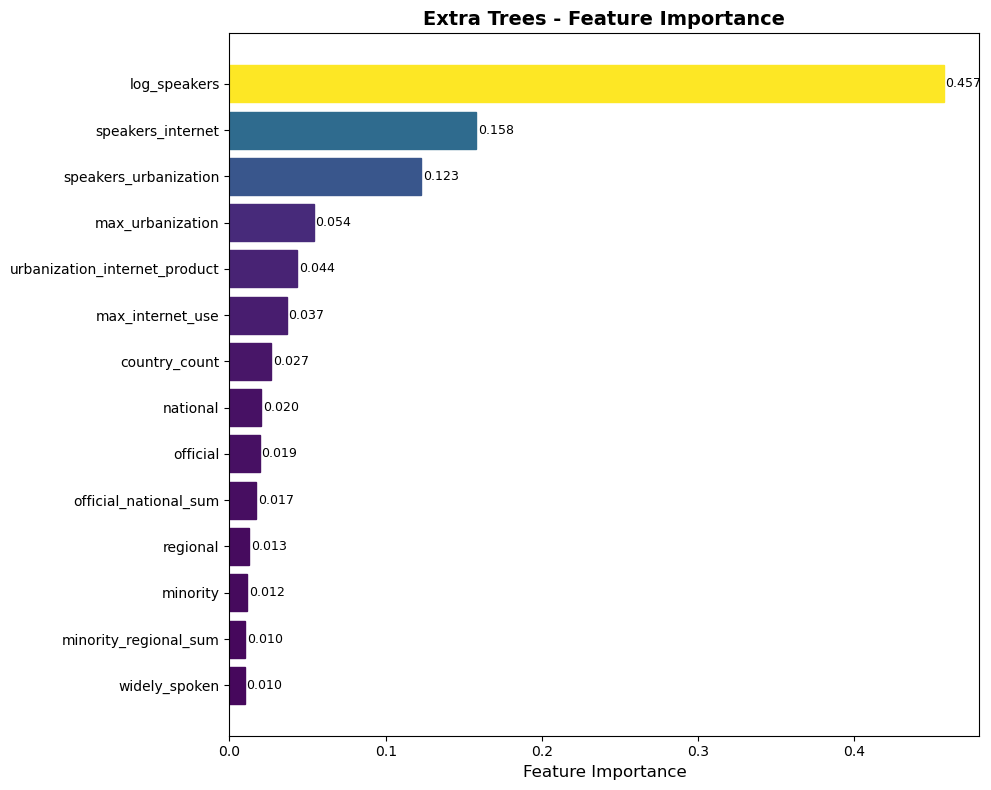


Top 10 Features for Extra Trees:
                      feature  importance
                 log_speakers    0.457078
            speakers_internet    0.157910
        speakers_urbanization    0.122825
             max_urbanization    0.054094
urbanization_internet_product    0.043533
             max_internet_use    0.036813
                country_count    0.026637
                     national    0.020421
                     official    0.019441
        official_national_sum    0.017143


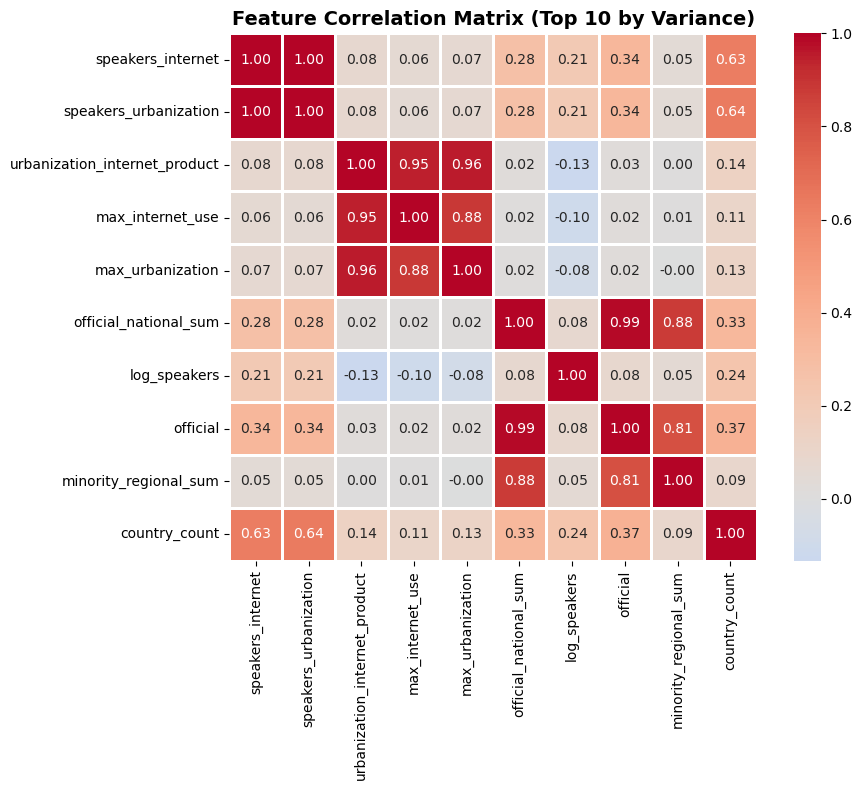

In [15]:
# Granular levels
plot_all_feature_importances(best_model1, features1)

# Comparison heatmap:
create_feature_importance_comparison(best_model1, features1)

# Feature correlation analysis:
analyze_feature_correlations(df, features1)

FEATURE IMPORTANCE ANALYSIS


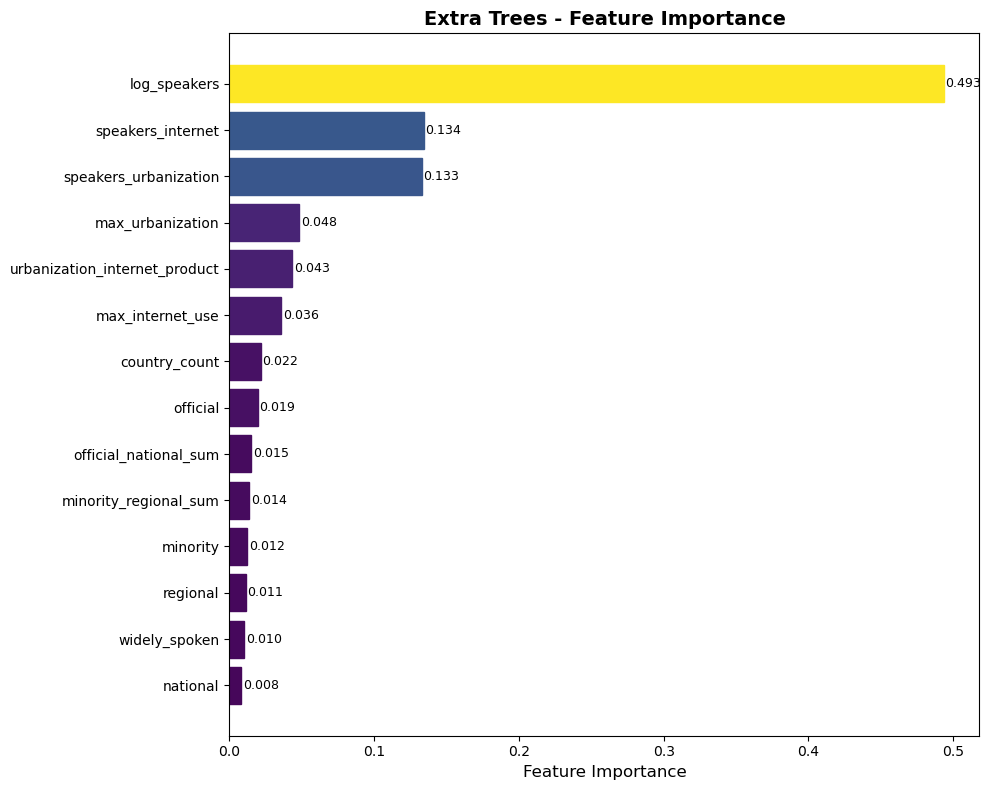


Top 10 Features for Extra Trees:
                      feature  importance
                 log_speakers    0.493440
            speakers_internet    0.134289
        speakers_urbanization    0.132993
             max_urbanization    0.048310
urbanization_internet_product    0.043402
             max_internet_use    0.035817
                country_count    0.021646
                     official    0.019451
        official_national_sum    0.015043
        minority_regional_sum    0.013682


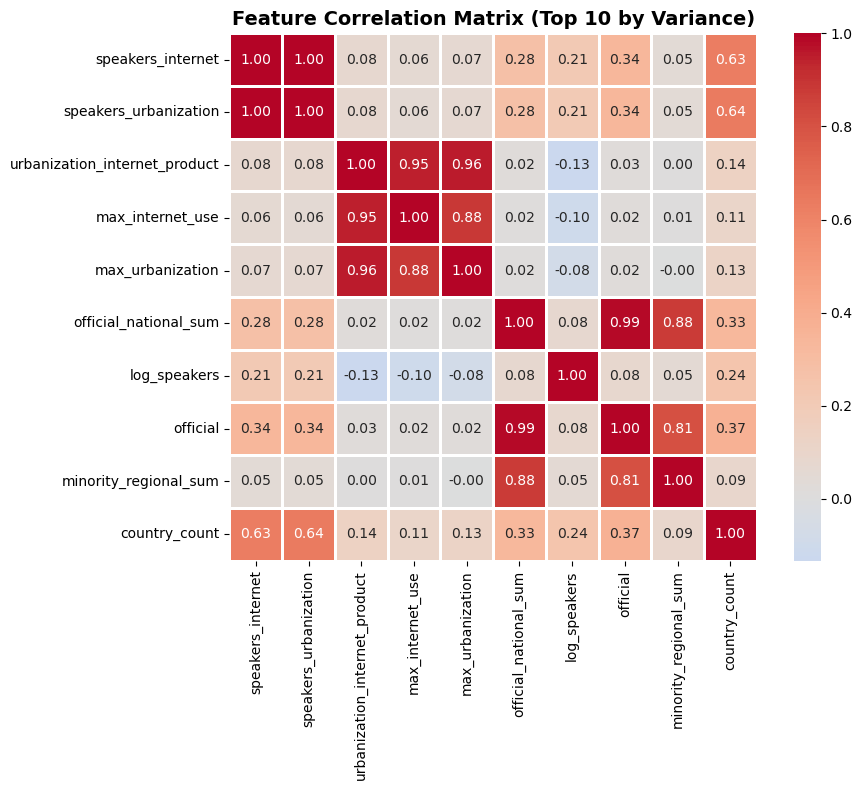

In [16]:
# Grouped levels
plot_all_feature_importances(best_model2, features2)

# Comparison heatmap:
create_feature_importance_comparison(best_model2, features2)

# Feature correlation analysis:
analyze_feature_correlations(df_modified, features2)